In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 30

In [3]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
# META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"
META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/model.ckpt-1664.meta"
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/model.ckpt-1664


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 30

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [13]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [14]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [15]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [29]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    if light == False:
        compute_and_print_steps(sats, RandomVarDPLL)
        compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, HybridDPLL)
    if light == False:
        compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

 50%|█████     | 5/10 [00:00<00:00, 17.00it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 24.11it/s]


#Sats: 10; avg step: 934.00; stdev step: 740.59; avg error: 7.60; stdev error: 1.74


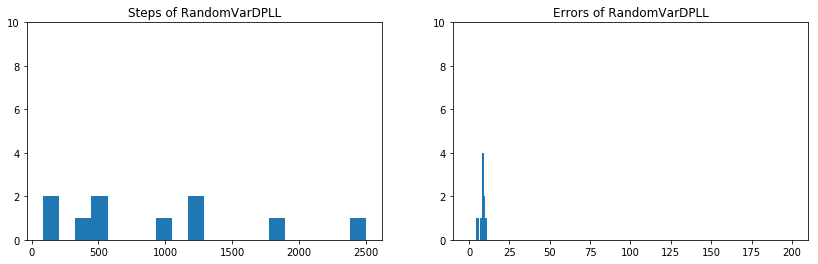

100%|██████████| 10/10 [00:00<00:00, 20.49it/s]


#Sats: 10; avg step: 750.30; stdev step: 472.77; avg error: 5.50; stdev error: 1.43


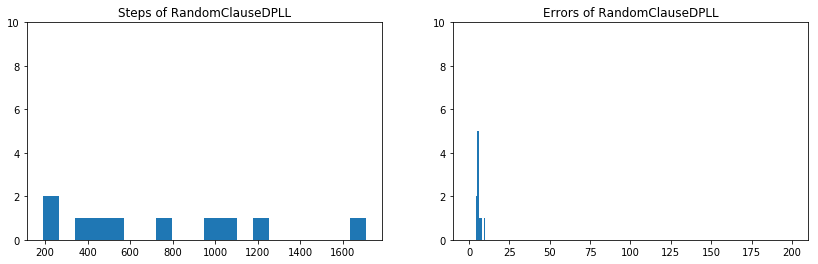

100%|██████████| 10/10 [00:27<00:00,  1.84s/it]


#Sats: 10; avg step: 348.90; stdev step: 371.55; avg error: 1.20; stdev error: 1.40


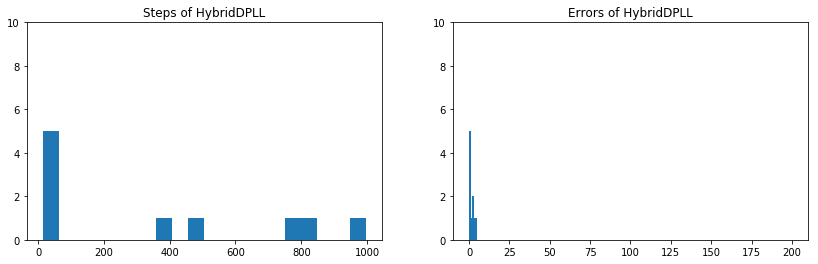

100%|██████████| 10/10 [01:22<00:00,  4.51s/it]


#Sats: 10; avg step: 376.80; stdev step: 389.98; avg error: 0.50; stdev error: 0.50


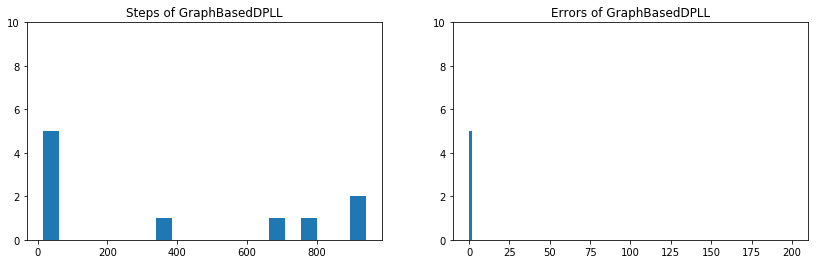

100%|██████████| 10/10 [00:00<00:00, 48.03it/s]


#Sats: 10; avg step: 235.20; stdev step: 314.86; avg error: 2.00; stdev error: 0.89


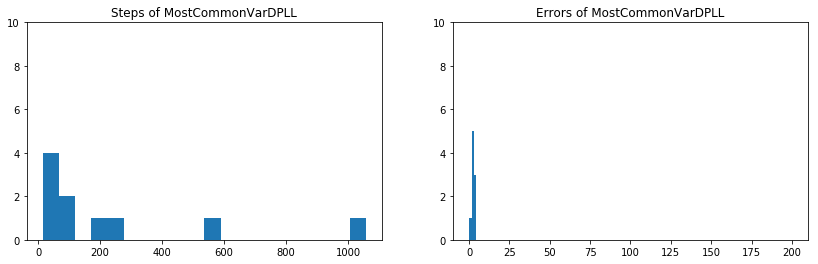

In [17]:
print_all(10, 200, 15)

100%|██████████| 10/10 [00:00<00:00, 368.01it/s]

We have generated 10 formulas
#Sats: 10; avg step: 73.20; stdev step: 32.05; avg error: 5.00; stdev error: 1.34


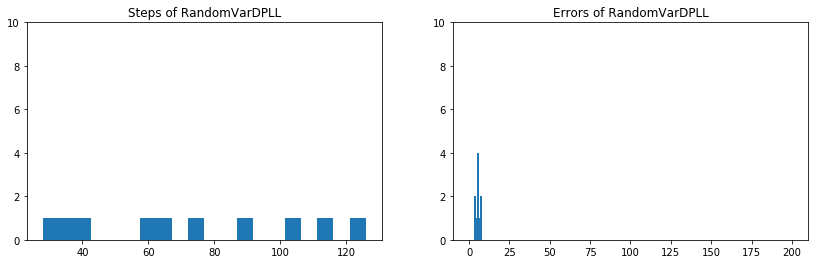

100%|██████████| 10/10 [00:00<00:00, 207.55it/s]


#Sats: 10; avg step: 61.60; stdev step: 32.90; avg error: 3.20; stdev error: 1.40


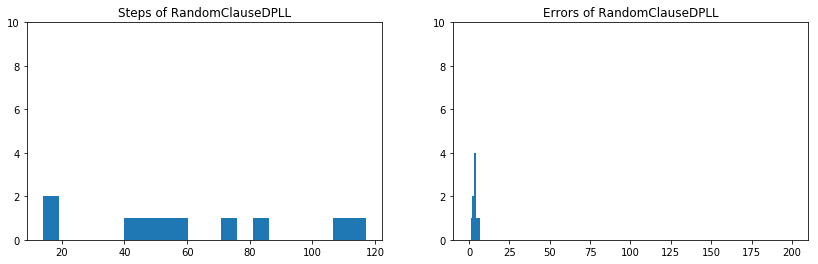

100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


#Sats: 10; avg step: 25.50; stdev step: 25.64; avg error: 0.30; stdev error: 0.46


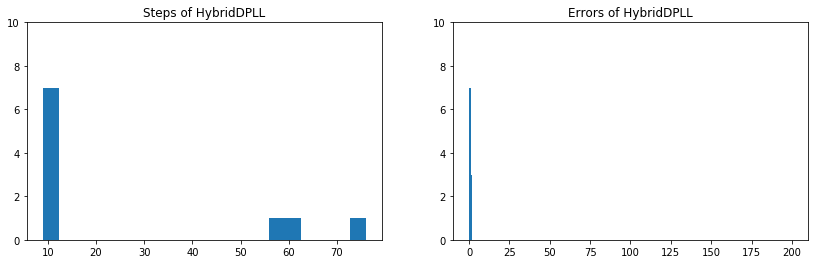

100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


#Sats: 10; avg step: 25.50; stdev step: 25.64; avg error: 0.30; stdev error: 0.46


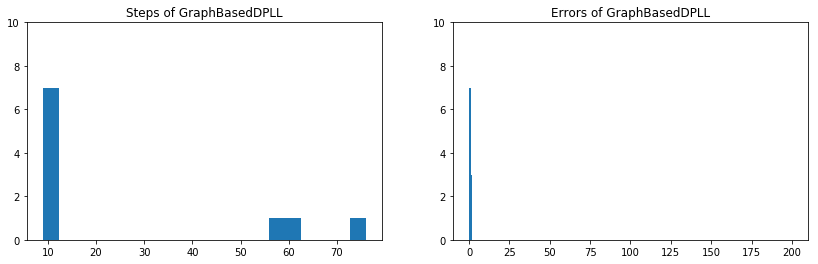

100%|██████████| 10/10 [00:00<00:00, 306.08it/s]


#Sats: 10; avg step: 30.00; stdev step: 27.30; avg error: 0.80; stdev error: 0.87


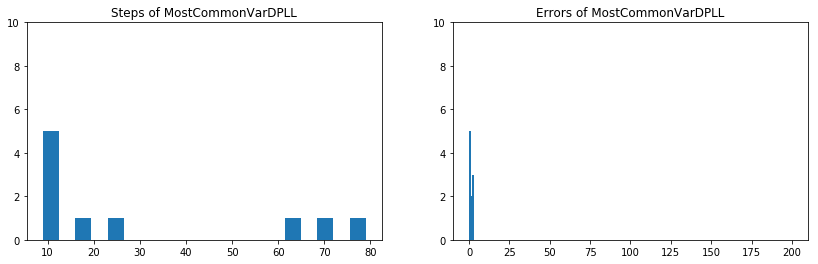

In [18]:
print_all(10, 200, 8)

100%|██████████| 10/10 [00:00<00:00, 176.55it/s]

We have generated 10 formulas
#Sats: 10; avg step: 146.00; stdev step: 89.37; avg error: 5.20; stdev error: 0.87


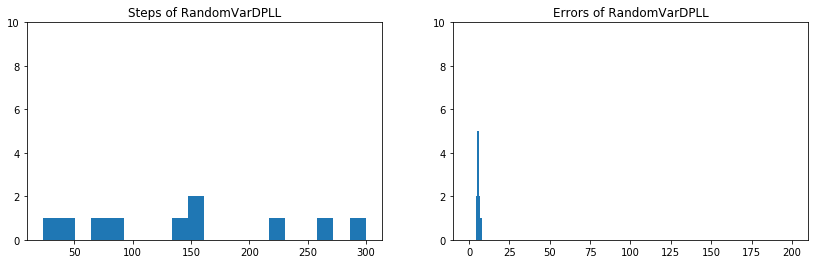

100%|██████████| 10/10 [00:00<00:00, 134.65it/s]


#Sats: 10; avg step: 92.00; stdev step: 46.48; avg error: 2.50; stdev error: 1.28


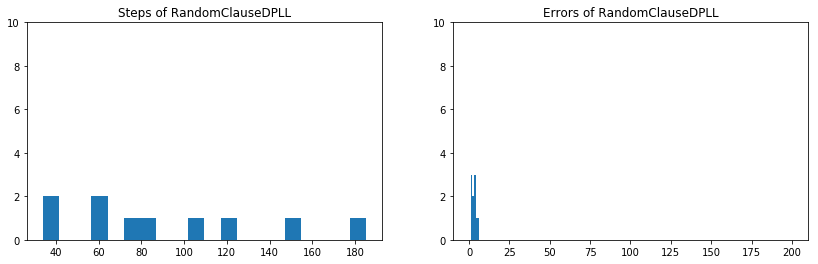

100%|██████████| 10/10 [00:11<00:00,  1.52s/it]


#Sats: 10; avg step: 62.50; stdev step: 85.72; avg error: 0.70; stdev error: 1.27


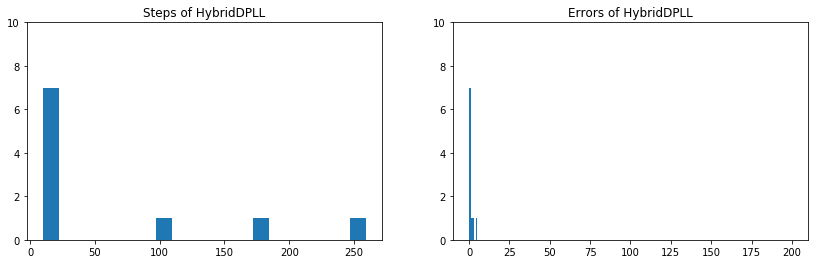

100%|██████████| 10/10 [00:12<00:00,  1.53s/it]


#Sats: 10; avg step: 63.40; stdev step: 87.80; avg error: 0.60; stdev error: 1.02


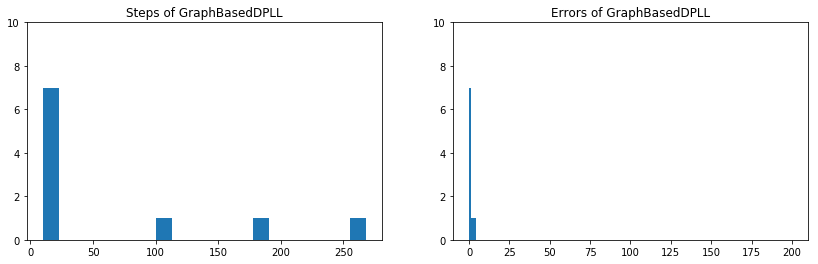

100%|██████████| 10/10 [00:00<00:00, 292.18it/s]


#Sats: 10; avg step: 63.20; stdev step: 35.80; avg error: 1.50; stdev error: 0.92


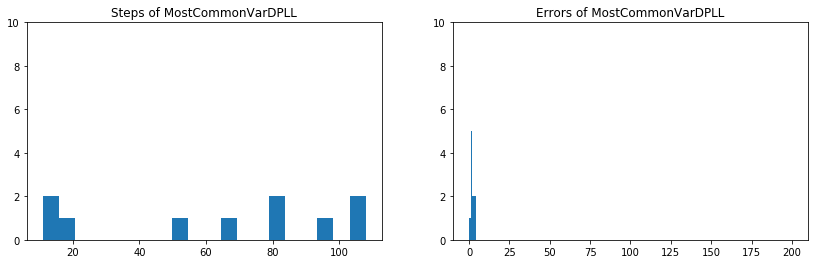

In [19]:
print_all(10, 200, 10)

100%|██████████| 10/10 [00:00<00:00, 63.52it/s]

We have generated 10 formulas
#Sats: 10; avg step: 263.90; stdev step: 222.66; avg error: 6.90; stdev error: 0.70


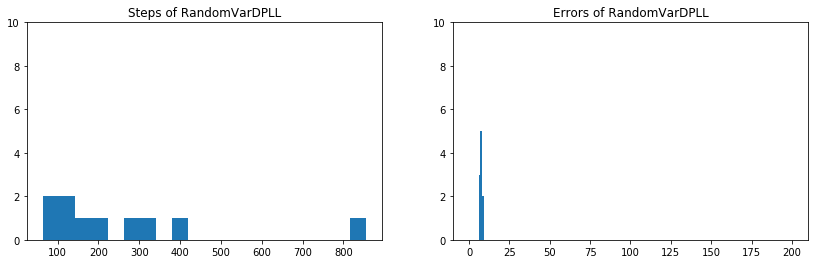

100%|██████████| 10/10 [00:00<00:00, 65.01it/s]


#Sats: 10; avg step: 209.20; stdev step: 100.44; avg error: 3.60; stdev error: 1.69


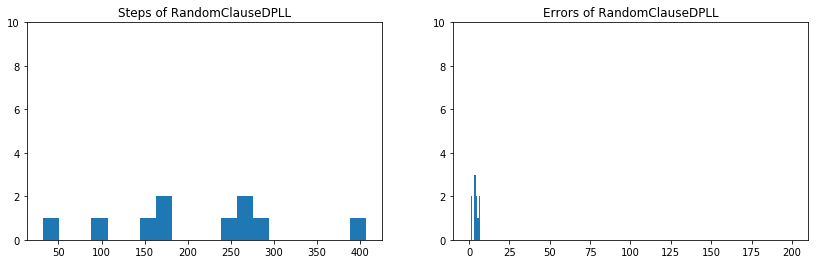

100%|██████████| 10/10 [00:08<00:00,  1.72it/s]


#Sats: 10; avg step: 31.90; stdev step: 57.70; avg error: 0.10; stdev error: 0.30


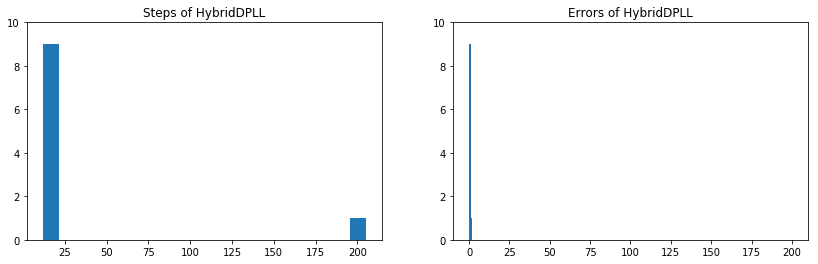

100%|██████████| 10/10 [00:08<00:00,  1.73it/s]


#Sats: 10; avg step: 31.90; stdev step: 57.70; avg error: 0.10; stdev error: 0.30


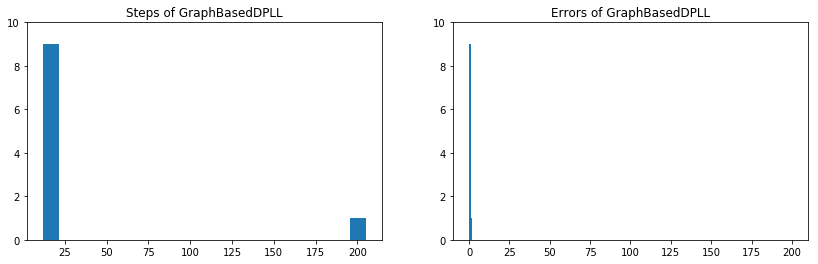

100%|██████████| 10/10 [00:00<00:00, 80.95it/s]


#Sats: 10; avg step: 102.20; stdev step: 72.16; avg error: 1.70; stdev error: 1.49


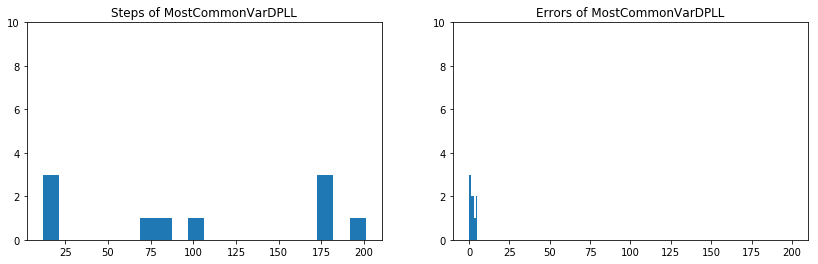

In [20]:
print_all(10, 200, 12)

 60%|██████    | 6/10 [00:00<00:00, 15.95it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 25.60it/s]


#Sats: 10; avg step: 709.70; stdev step: 392.62; avg error: 5.50; stdev error: 1.43


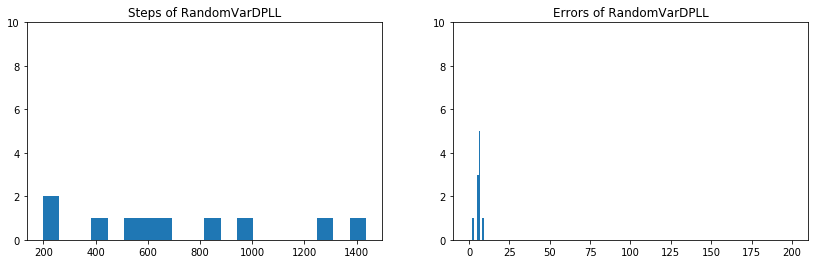

100%|██████████| 10/10 [00:00<00:00, 58.07it/s]


#Sats: 10; avg step: 266.50; stdev step: 180.29; avg error: 3.80; stdev error: 1.40


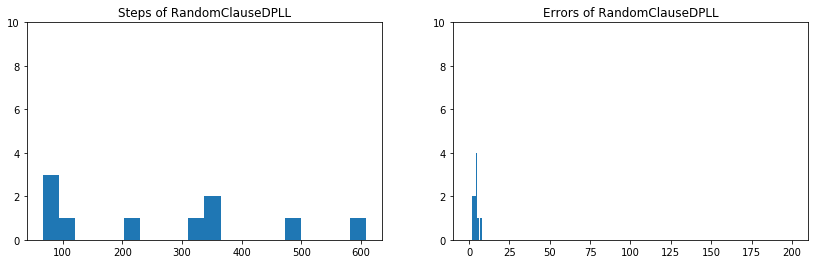

100%|██████████| 10/10 [00:16<00:00,  1.91s/it]


#Sats: 10; avg step: 161.00; stdev step: 227.64; avg error: 1.30; stdev error: 2.10


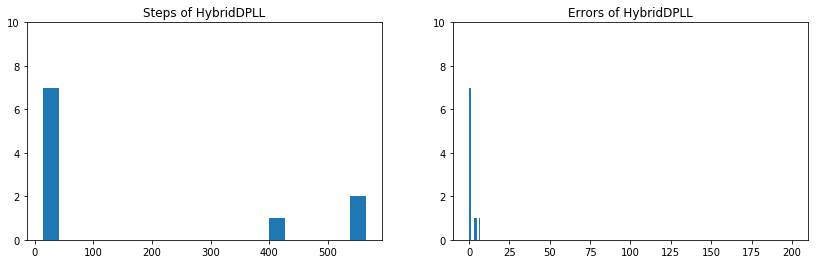

100%|██████████| 10/10 [00:36<00:00,  4.85s/it]


#Sats: 10; avg step: 159.80; stdev step: 234.30; avg error: 0.30; stdev error: 0.46


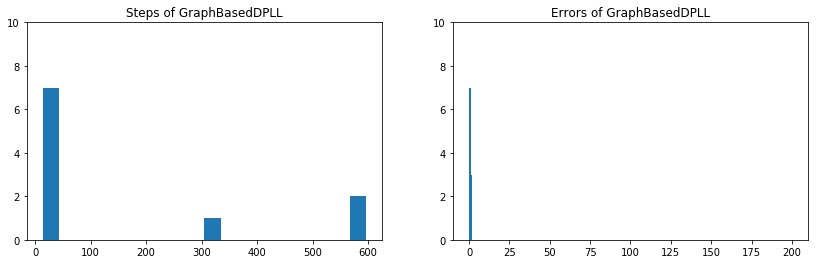

100%|██████████| 10/10 [00:00<00:00, 51.63it/s]


#Sats: 10; avg step: 238.40; stdev step: 163.05; avg error: 2.00; stdev error: 1.18


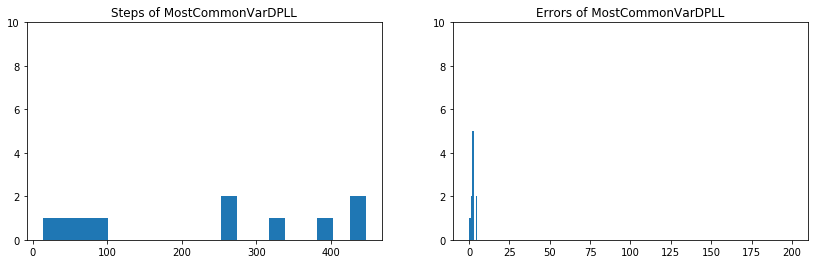

In [21]:
print_all(10, 200, 14)

 40%|████      | 4/10 [00:00<00:00, 11.21it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 12.23it/s]


#Sats: 10; avg step: 1391.70; stdev step: 612.74; avg error: 8.30; stdev error: 1.73


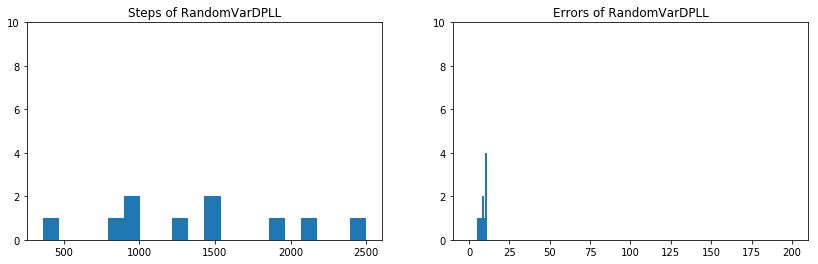

100%|██████████| 10/10 [00:00<00:00, 20.72it/s]


#Sats: 10; avg step: 817.10; stdev step: 557.30; avg error: 4.70; stdev error: 1.42


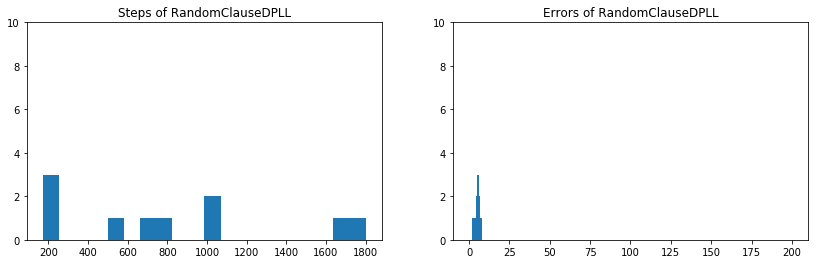

100%|██████████| 10/10 [00:18<00:00,  2.41s/it]


#Sats: 10; avg step: 204.40; stdev step: 326.99; avg error: 0.80; stdev error: 1.40


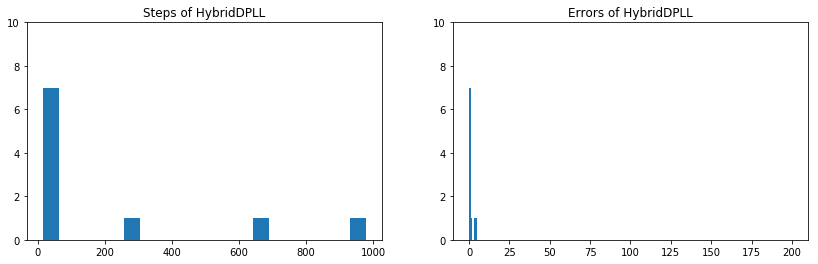

100%|██████████| 10/10 [01:07<00:00, 14.63s/it]


#Sats: 10; avg step: 301.60; stdev step: 558.05; avg error: 0.40; stdev error: 0.66


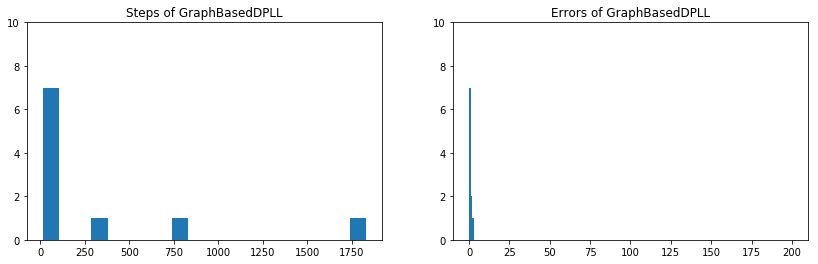

100%|██████████| 10/10 [00:00<00:00, 59.93it/s]


#Sats: 10; avg step: 220.20; stdev step: 356.60; avg error: 2.50; stdev error: 1.75


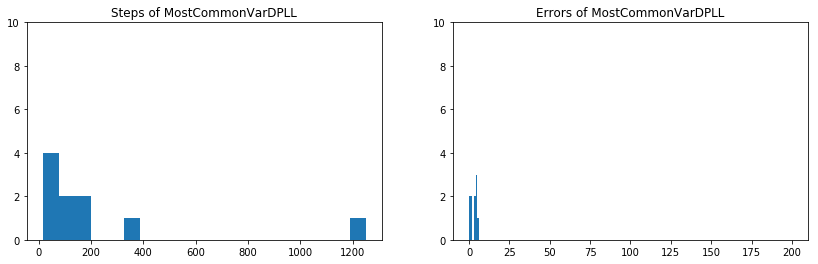

In [22]:
print_all(10, 200, 16)

 10%|█         | 1/10 [00:00<00:02,  3.31it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


#Sats: 10; avg step: 3016.80; stdev step: 1770.49; avg error: 10.00; stdev error: 3.38


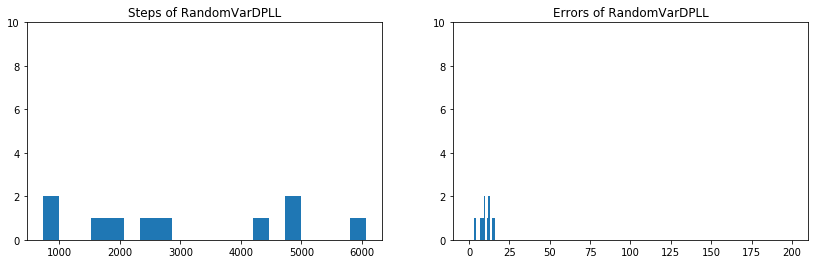

100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


#Sats: 10; avg step: 998.40; stdev step: 842.57; avg error: 4.40; stdev error: 1.62


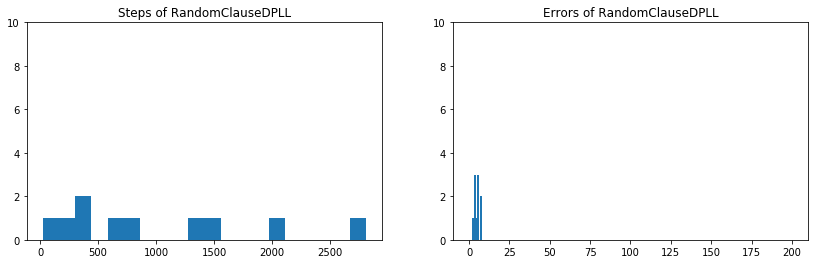

100%|██████████| 10/10 [00:19<00:00,  1.28s/it]


#Sats: 10; avg step: 344.00; stdev step: 529.44; avg error: 0.90; stdev error: 1.45


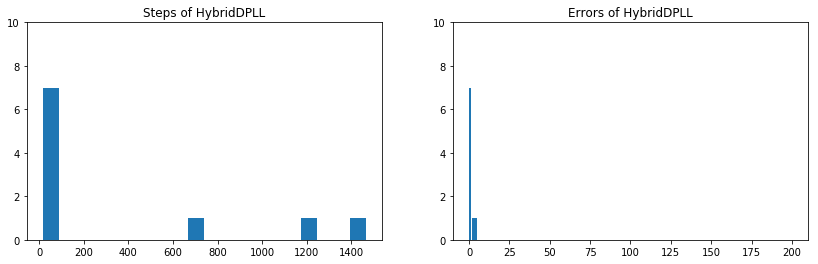

100%|██████████| 10/10 [01:45<00:00,  3.86s/it]


#Sats: 10; avg step: 449.80; stdev step: 767.32; avg error: 0.30; stdev error: 0.46


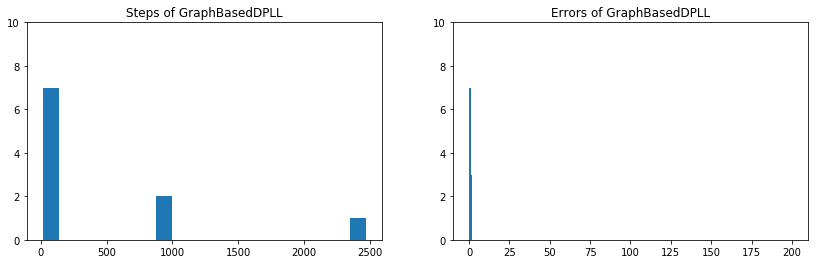

100%|██████████| 10/10 [00:00<00:00, 14.41it/s]


#Sats: 10; avg step: 609.30; stdev step: 731.25; avg error: 3.10; stdev error: 0.83


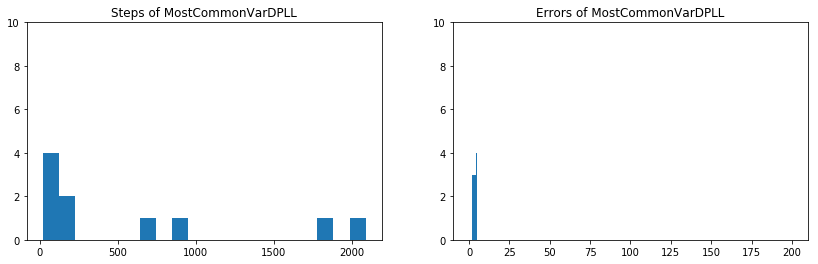

In [23]:
print_all(10, 200, 18)

 40%|████      | 4/10 [00:00<00:00,  9.57it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


#Sats: 10; avg step: 4419.70; stdev step: 2610.40; avg error: 10.60; stdev error: 2.01


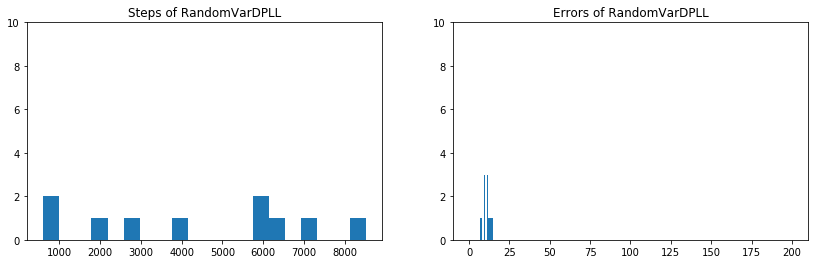

100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


#Sats: 10; avg step: 3218.20; stdev step: 1912.92; avg error: 5.50; stdev error: 2.42


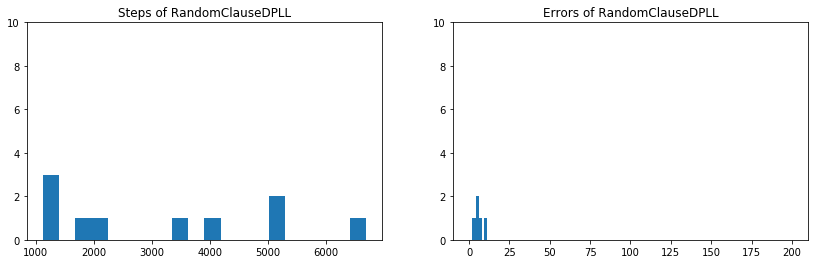

100%|██████████| 10/10 [00:26<00:00,  3.57s/it]


#Sats: 10; avg step: 570.70; stdev step: 643.78; avg error: 1.40; stdev error: 1.43


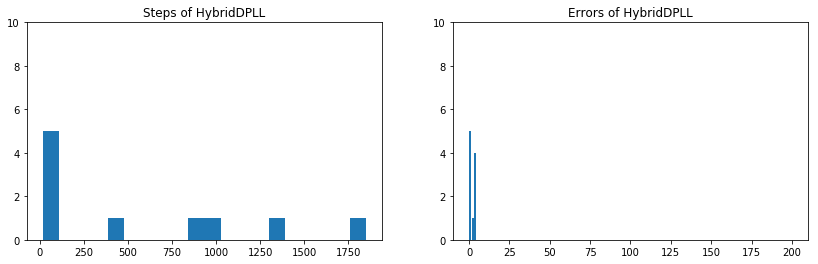

100%|██████████| 10/10 [05:04<00:00, 41.20s/it]


#Sats: 10; avg step: 1325.80; stdev step: 1759.71; avg error: 0.60; stdev error: 0.66


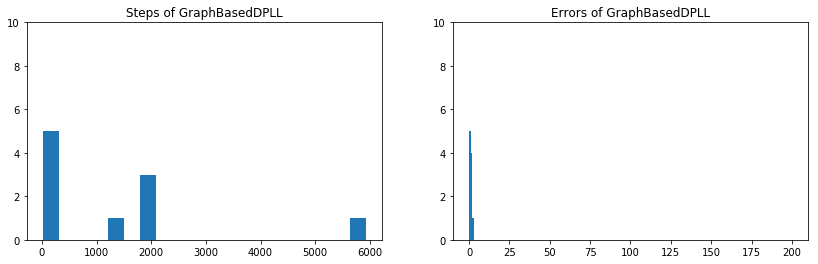

100%|██████████| 10/10 [00:00<00:00,  9.15it/s]


#Sats: 10; avg step: 1280.60; stdev step: 1322.87; avg error: 2.90; stdev error: 1.58


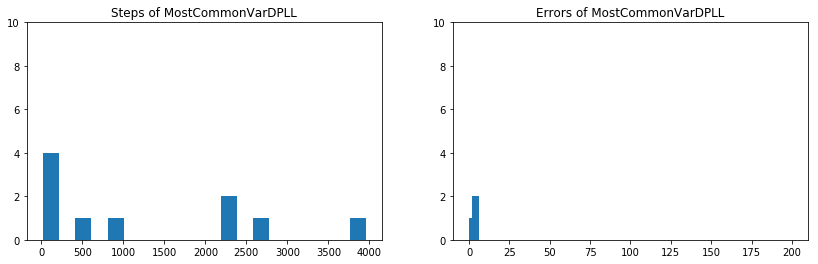

In [24]:
print_all(10, 200, 20)

 20%|██        | 2/10 [00:00<00:03,  2.33it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


#Sats: 10; avg step: 15971.40; stdev step: 11628.12; avg error: 11.90; stdev error: 2.07


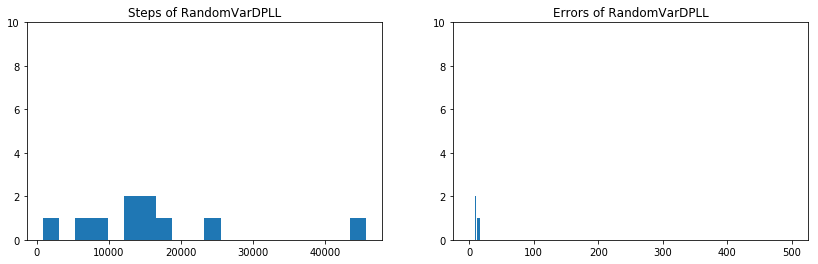

100%|██████████| 10/10 [00:11<00:00,  1.26s/it]


#Sats: 10; avg step: 18459.50; stdev step: 10271.80; avg error: 8.70; stdev error: 2.45


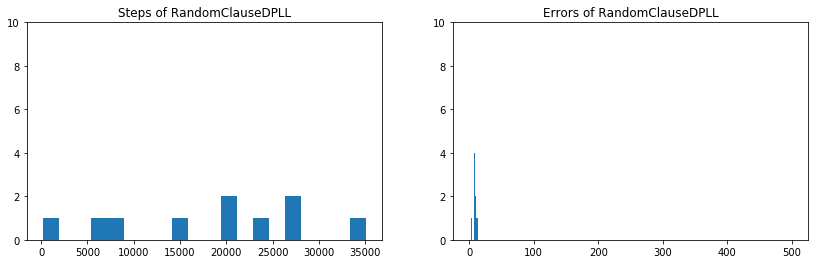

100%|██████████| 10/10 [00:34<00:00,  3.83s/it]


#Sats: 10; avg step: 862.50; stdev step: 1124.82; avg error: 1.70; stdev error: 1.85


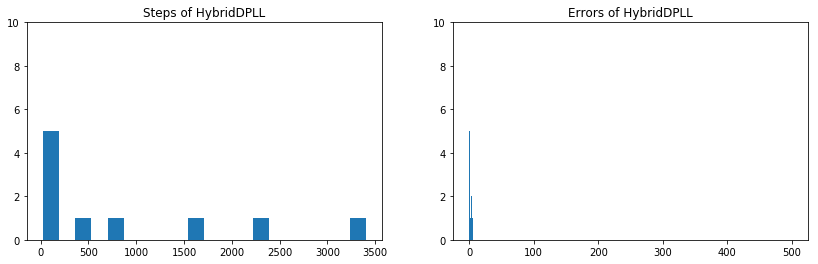

100%|██████████| 10/10 [05:31<00:00, 38.56s/it]


#Sats: 10; avg step: 1188.50; stdev step: 1653.36; avg error: 0.50; stdev error: 0.50


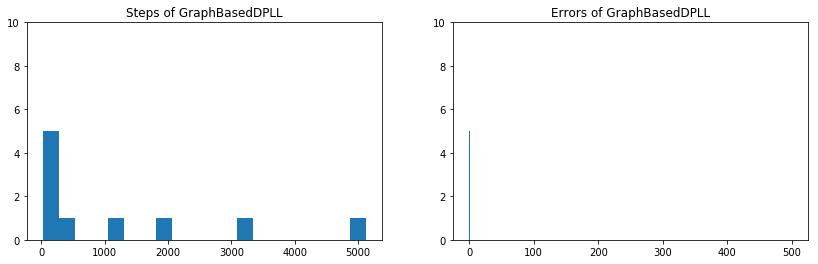

100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


#Sats: 10; avg step: 5006.00; stdev step: 4064.25; avg error: 3.90; stdev error: 1.37


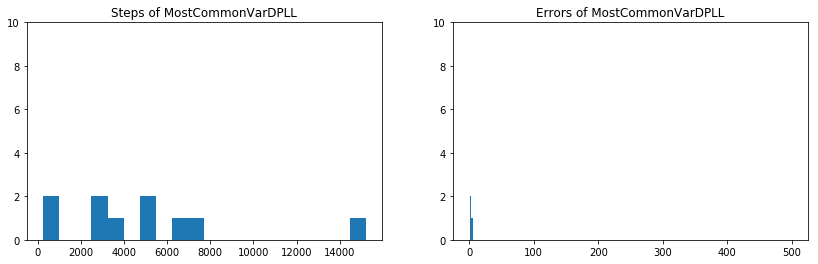

In [25]:
print_all(10, 500, 25)

 10%|█         | 1/10 [00:18<02:43, 18.15s/it]

We have generated 10 formulas


100%|██████████| 10/10 [02:16<00:00, 15.02s/it]


#Sats: 10; avg step: 180269.60; stdev step: 98662.89; avg error: 14.90; stdev error: 3.21


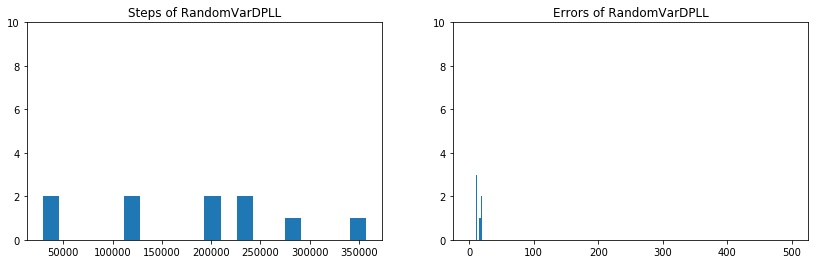

100%|██████████| 10/10 [00:55<00:00,  5.10s/it]


#Sats: 10; avg step: 67156.20; stdev step: 37842.90; avg error: 11.00; stdev error: 1.55


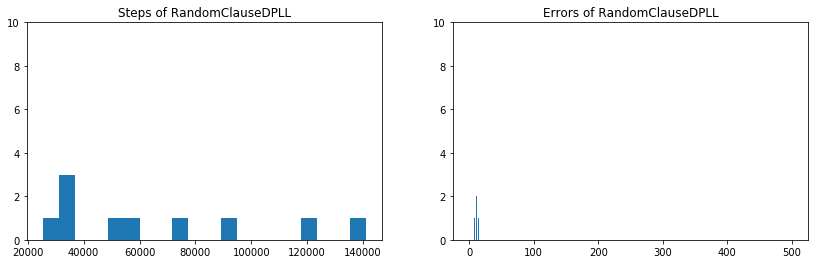

100%|██████████| 10/10 [00:50<00:00,  3.53s/it]


#Sats: 10; avg step: 11445.30; stdev step: 15657.58; avg error: 2.30; stdev error: 2.90


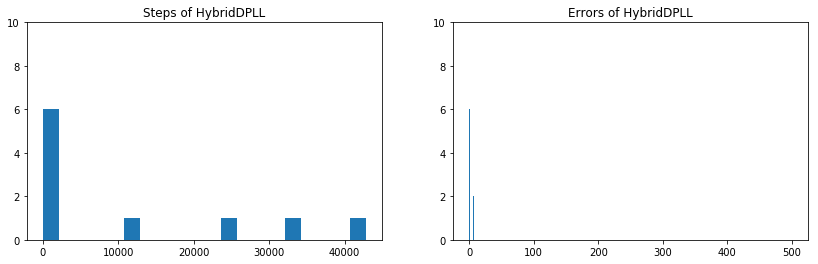

100%|██████████| 10/10 [4:12:20<00:00, 609.42s/it]  


#Sats: 10; avg step: 44090.60; stdev step: 62379.29; avg error: 0.70; stdev error: 1.19


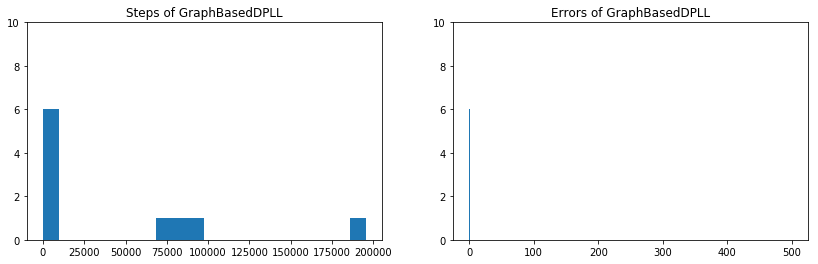

100%|██████████| 10/10 [00:13<00:00,  1.81s/it]


#Sats: 10; avg step: 14766.30; stdev step: 13380.45; avg error: 4.70; stdev error: 2.19


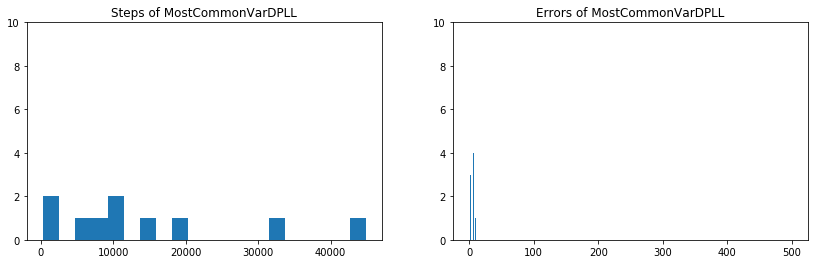

In [26]:
print_all(10, 500, 30)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [03:16<00:00, 16.73s/it]


#Sats: 10; avg step: 103511.40; stdev step: 122242.91; avg error: 3.70; stdev error: 3.07


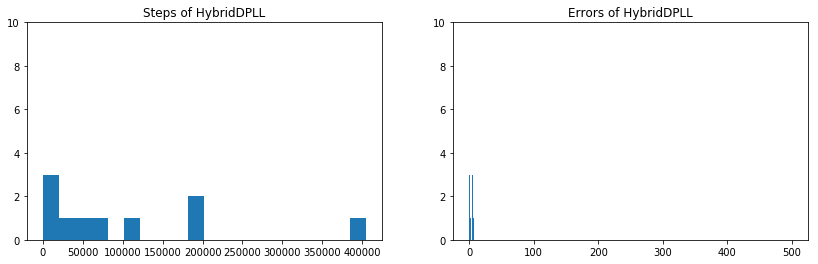

100%|██████████| 10/10 [04:17<00:00, 29.57s/it]


#Sats: 10; avg step: 204541.50; stdev step: 145486.35; avg error: 6.30; stdev error: 2.53


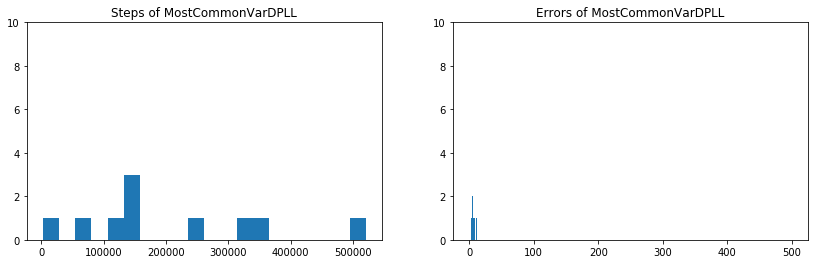

In [30]:
print_all(10, 500, 40, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [43:31<00:00, 406.28s/it]


#Sats: 10; avg step: 1739612.30; stdev step: 2270507.33; avg error: 4.70; stdev error: 4.27


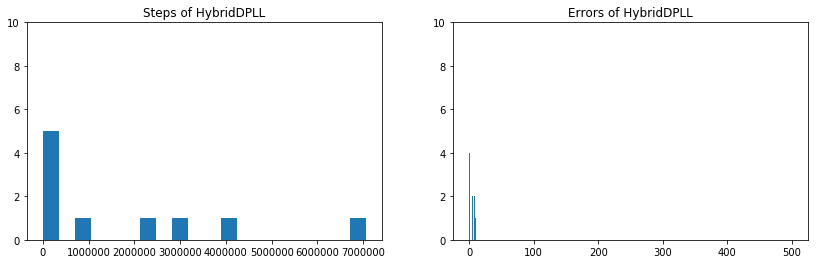

100%|██████████| 10/10 [1:30:10<00:00, 562.53s/it]


#Sats: 10; avg step: 3515298.40; stdev step: 3857098.64; avg error: 8.10; stdev error: 2.21


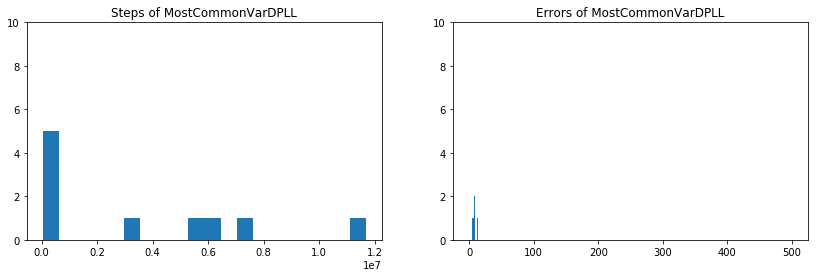

In [31]:
print_all(10, 500, 50, light=True)